In [25]:
import numpy as np
from matplotlib import pyplot as plt
import ctypes
from ctypes import POINTER, c_int, c_double, c_void_p, c_char_p
import sys

%matplotlib inline

In [26]:
!make main.so

make: 'main.so' is up to date.


In [27]:
lib = ctypes.CDLL("./main.so")
lib.parse.restype = c_void_p
lib.parse.argtypes = [c_char_p]

In [28]:
def call_func(func, fs, n, h, x0, y0):
    out_x = np.zeros(n, dtype=np.float64)
    out_y = np.zeros(n, dtype=np.float64)
    ptr_x = out_x.__array_interface__['data'][0]
    ptr_y = out_y.__array_interface__['data'][0]
    f = lib.parse(fs.encode())
    func.argtypes = [c_void_p, c_int, c_double, c_double, c_double, c_void_p, c_void_p]
    func(f, n, h, x0, y0, ptr_x, ptr_y)
    return out_x, out_y

def call_big_func(func, fs, accur, n, h, x0, y0):
    out_x = np.zeros(n, dtype=np.float64)
    out_y = np.zeros(n, dtype=np.float64)
    ptr_x = out_x.__array_interface__['data'][0]
    ptr_y = out_y.__array_interface__['data'][0]
    f = lib.parse(fs.encode())
    func.argtypes = [c_void_p, c_int, c_int, c_double, c_double, c_double, c_void_p, c_void_p]
    func(f, accur, n, h, x0, y0, ptr_x, ptr_y)
    return out_x, out_y


In [29]:
call_func(lib.euler, 'sin(x)', 10, 0.2, 0.0, 0.0)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8]),
 array([0.        , 0.        , 0.03973387, 0.11761753, 0.23054603,
        0.37401725, 0.54231144, 0.72871926, 0.92580921, 1.12572393]))

In [30]:
call_func(lib.adams, 'sin(x)', 10, 0.2, 0.0, 0.0)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8]),
 array([0.        , 0.        , 0.0596008 , 0.15655937, 0.28701028,
        0.44575286, 0.62645854, 0.82192317, 1.02435418, 1.22568129]))

In [31]:
call_big_func(lib.modificate_euler, 'sin(x)', 1, 10, 0.01, 0.0, 0.0)

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
 array([0.00000000e+00, 4.99991667e-05, 1.99991667e-04, 4.49962501e-04,
        7.99886673e-04, 1.24972919e-03, 1.79944507e-03, 2.44897934e-03,
        3.19826704e-03, 4.04723326e-03]))

In [32]:
call_big_func(lib.modificate_euler, 'sin(x)', 10, 10, 0.01, 0.0, 0.0)

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
 array([0.00000000e+00, 4.99991667e-05, 1.99991667e-04, 4.49962501e-04,
        7.99886673e-04, 1.24972919e-03, 1.79944507e-03, 2.44897934e-03,
        3.19826704e-03, 4.04723326e-03]))

In [49]:
funcs = ["1 / x", "cos(x)", "y + 1", "x + y", "exp(y)"]
corrects = [lambda x: np.log(x), lambda x: np.sin(x), lambda x: np.exp(x) - 1, lambda x: np.exp(x) - x - 1, lambda x: -np.log(12 - x)]
ns = [10, 100, 10 ** 4, 10 ** 6]
for i in range(len(funcs)):
    print('y\' = ' + funcs[i], end='\t')
    for j in range(len(ns)):
        result = call_func(lib.adams, funcs[i], ns[j], 10 / ns[j], 1, corrects[i](1))
        corr = corrects[i](result[0])
        loss = (np.abs(corr - result[1])).max()
        print('{:e}'.format(loss), end='\t')
    print('')

y' = 1 / x	3.068528e-01	4.689820e-03	4.996669e-07	4.999960e-11	
y' = cos(x)	4.724759e-01	4.866630e-03	4.867892e-07	1.256302e-10	
y' = y + 1	1.810495e+04	2.282702e+03	2.789282e-01	1.324980e-05	
y' = x + y	1.810495e+04	2.282702e+03	2.789282e-01	1.315401e-05	
y' = exp(y)	1.088160e-01	6.017498e-03	8.006471e-07	1.649053e-10	


In [48]:
funcs = ["1 / x", "cos(x)", "y + 1", "x + y", "exp(y)"]
corrects = [lambda x: np.log(x), lambda x: np.sin(x), lambda x: np.exp(x) - 1, lambda x: np.exp(x) - x - 1, lambda x: -np.log(12 - x)]
ns = [10, 100, 10 ** 4, 10 ** 6]
for i in range(len(funcs)):
    print('y\' = ' + funcs[i], end='\t')
    for j in range(len(ns)):
        result = call_big_func(lib.modificate_euler, funcs[i], 100, ns[j], 10 / ns[j], 1, corrects[i](1))
        corr = corrects[i](result[0])
        loss = (np.abs(corr - result[1])).max()
        print('{:e}'.format(loss), end='\t')
    print('')

y' = 1 / x	7.638316e-02	8.254900e-04	8.264450e-08	8.256951e-12	
y' = cos(x)	1.525946e-01	1.534751e-03	1.534559e-07	1.536760e-11	
y' = y + 1	3.147748e+04	4.494810e+02	4.984029e-02	4.989168e-06	
y' = x + y	3.147748e+04	4.494810e+02	4.984029e-02	4.989706e-06	
y' = exp(y)	3.683479e-02	1.242661e-03	1.511975e-07	1.497624e-11	


In [37]:
def show(i, func=lib.euler, ff=call_func):
    n = 10
    corr = corrects[i](np.linspace(1, 11, 100))
    if ff is call_big_func:
        result = ff(func, funcs[i], 2, 10, 1, 1, corrects[i](1))
    else:
        result = ff(func, funcs[i], 10, 1, 1, corrects[i](1))
    plt.plot(np.linspace(1, 11, 100), corr)
    plt.plot(*result)

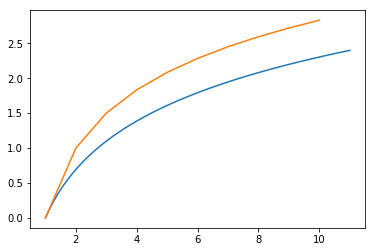

In [38]:
show(0)

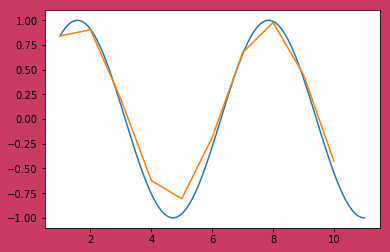

In [50]:
show(1, lib.modificate_euler, call_big_func)

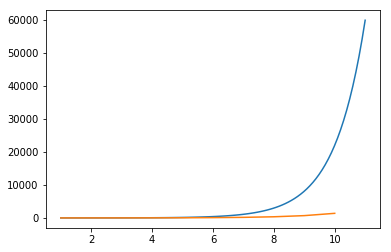

In [40]:
show(2)

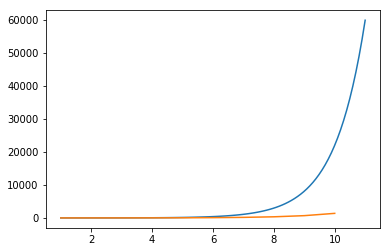

In [41]:
show(3)

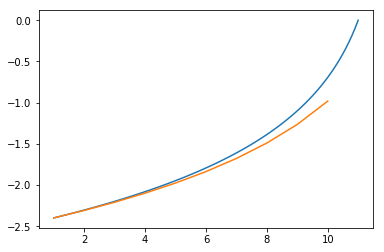

In [42]:
show(4)

In [46]:
(call_big_func(lib.modificate_euler, 'exp(-pow(x, 2))', 2, 30 * 10 ** 6, 1 / 15, -1e6, 0)[1][-1])

1.7724538509055152

[0.         0.7859389  1.52128622 1.05559139 1.03951656]
1.521286217615942
0.669325433302216
0.44342136258694964
0.3315907524151589


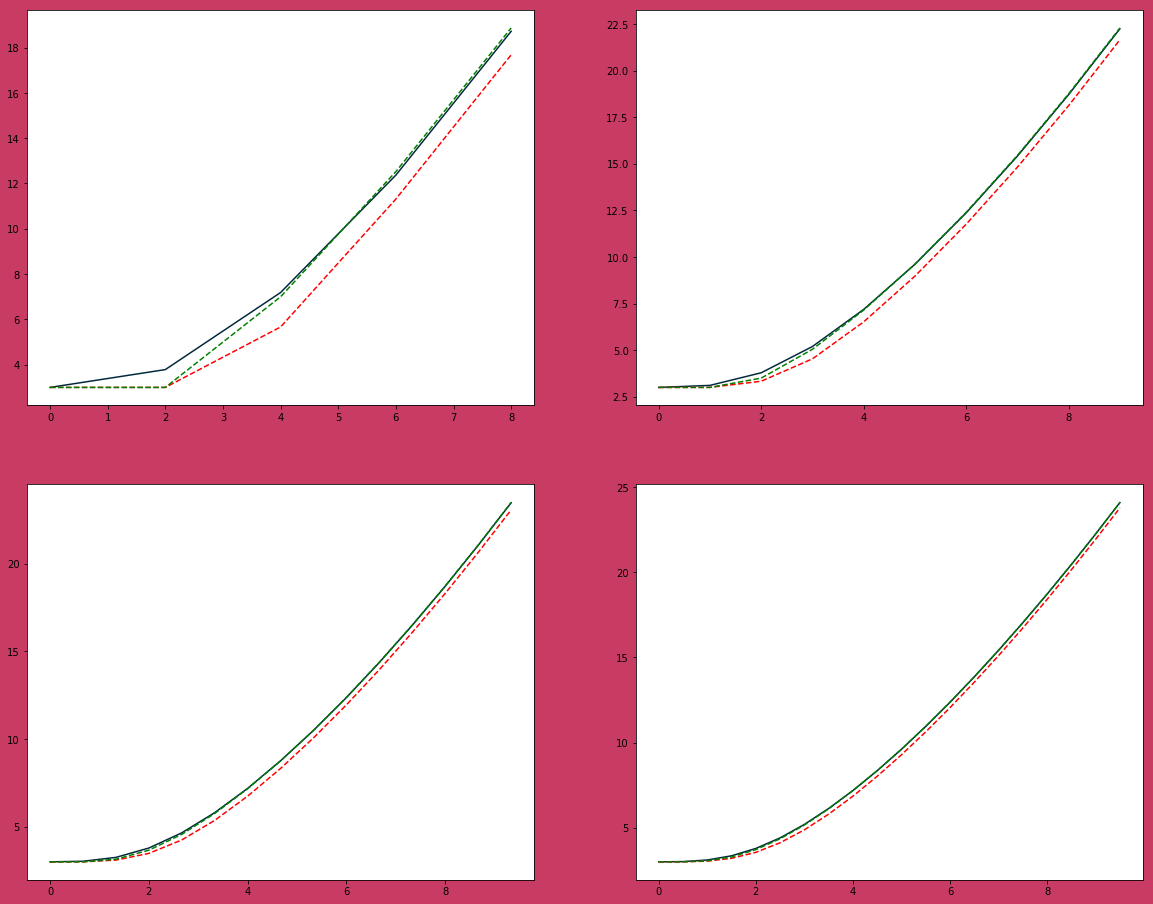

In [51]:
f = 'x * x / y'
x0 = 0
y0 = 3
plt.rcParams['figure.facecolor'] = '#C83C64'
plt.figure(figsize=(20, 16))
for i, n in enumerate([5, 10, 15, 20]):
    plt.subplot(2, 2, i + 1)
    x, y = call_func(lib.euler, f, n, 10 / n, 0, 3)
    c = np.sqrt(2 / 3 * x ** 3 + 9)
    plt.plot(x, c, '#02283C')
    plt.plot(x, y, '--r')
    if i == 0:
        print(np.abs(c - y))
    print(np.abs(c - y).max())
    x, y = call_func(lib.adams, f, n, 10 / n, 0, 3)
    plt.plot(x, y, '--g')

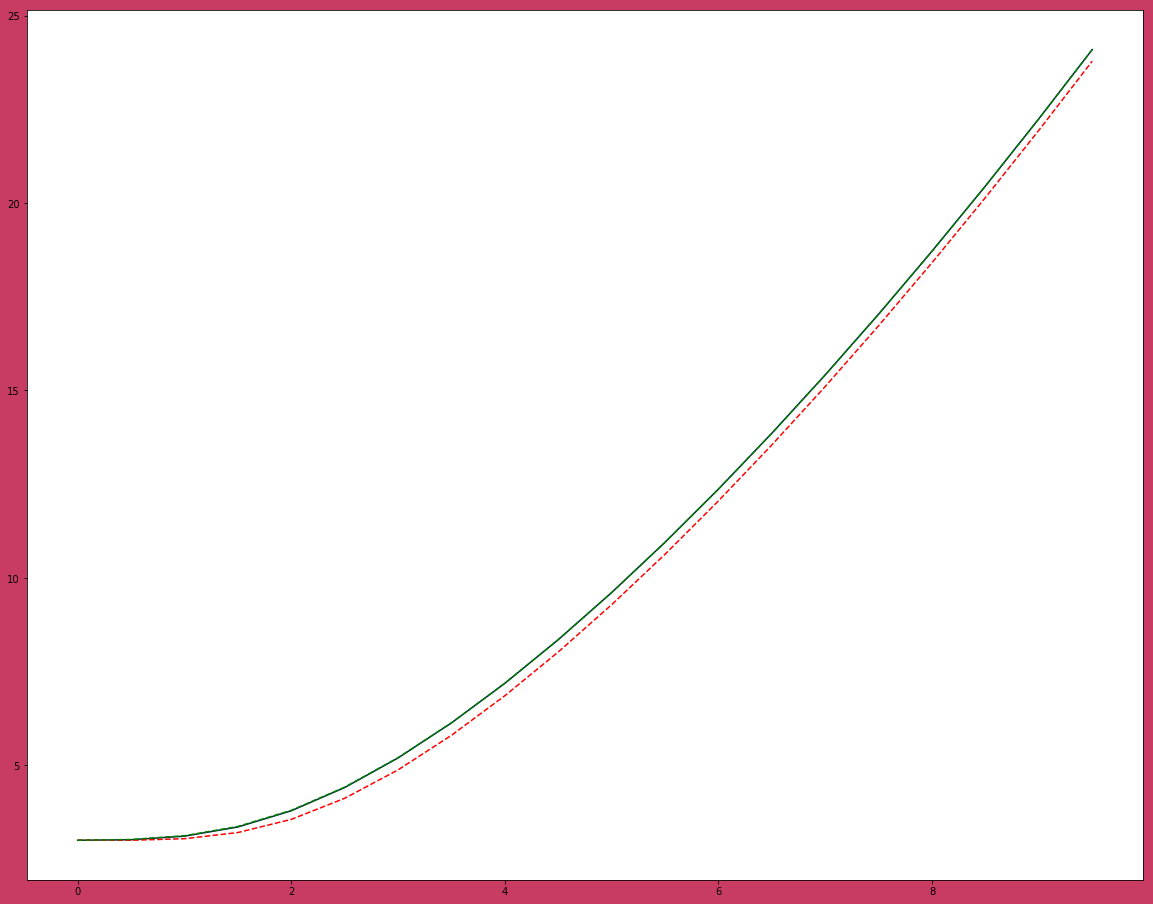

In [45]:
f = 'x * x / y'
x0 = 0
y0 = 3
plt.rcParams['figure.facecolor'] = '#C83C64'
plt.figure(figsize=(20, 16))
x, y = call_func(lib.euler, f, n, 10 / n, 0, 3)
c = np.sqrt(2 / 3 * x ** 3 + 9)
plt.plot(x, c, '#02283C')
plt.plot(x, y, '--r')
x, y = call_big_func(lib.modificate_euler, f, 10, n, 10 / n, 0, 3)
plt.plot(x, y, '--g')

In [ ]:
def f(x):
    return 5 * x + 2

fig = plt.figure()
x1, y1 = call_func(lib.euler, '5 * x + 2', 10, 0.2, 0.0, 0.0)
#x2, y2 = call_func(lib.adams, '5 * x + 2', 10, 0.2. 0.0, 0.0)
plt.plot(x1, y1, label='Line ')
plt.ylim([3, 8])
#plt.plot(x2, y2, 'ro')
plt.grid(True)
plt.show()